In [1]:
%matplotlib widget

from IPython.display import Markdown
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np

# Neumann Calculator
This script calculates the self and mutual indictances of a Tesla coil's primary and secondary windings. This is done by applying Neumann formula for the mutual inductance $M_{m,n}$ given two coil geometries $\gamma_m$ and $\gamma_n$
$$
M_{m,n} = \frac{\mu_0}{4\pi}\oint_{\gamma_m}\oint_{\gamma_n}\frac{\mathrm{d}\vec{x}_m \cdot \mathrm{d}\vec{x}_n}{\left|\vec{x}_m - \vec{x}_n\right|}.
$$
The equation above is readily discretized by considering short lengths of wire $\Delta \vec{x}_m$ and $\Delta \vec{x}_n$ as 
$$
M_{m, n} \approx \frac{\mu_0}{4\pi} \sum_{m}\sum_{n} \frac{\Delta\vec{x}_m \cdot \Delta\vec{x}_n}{\left|\vec{x}_m - \vec{x}_n\right|}.
$$
Note that we disregarded the "closing" term of the closed integral. This assumption is valid granted that the "closing" wire is orthogonally oriented with respect to the generated field.

## Geometry Definition
We begin by setting the simultation paramenters: from the coils geometries to the discretization steps.

In [2]:
# Primary coil radii
rp_i    = 0.01  # [m]
rp_f    = 0.2   # [m]
# Primary coil height
zp_i    = 0     # [m]
zp_f    = 0.15  # [m]
# Primary coil turns
Np      = 10    # [1]

# Secondary coil radius
rs      = 0.05  # [m]
# Secondary coil height
zs_i    = 0.05  # [m]
zs_f    = 0.55  # [m]
# Seconday coil turns
Ns      = 1000  # [1]
group   = 10    # [1] Grouping of effective turns into bunches

# Angle discretization discretization
d_theta = 0.1   # [rad] Angle between points

### Primary Coil Discretization
We first define a spiral in polar coordinates as
\begin{align}
    r(\theta) &=  (r_f - r_i) \frac{\theta}{2\pi N} + r_i, \\
    z(\theta) &= (z_f - z_i) \frac{\theta}{2\pi N} + z_i  \ , \quad 0 \le \theta \le 2\pi N.
\end{align}
We then transform the euqations in cartesian coordinates
\begin{align}
    x(\theta) &= r(\theta)\cos\theta = \left[(r_f - r_i) \frac{\theta}{2\pi N} + r_i\right]\cos\theta, \\
    y(\theta) &= r(\theta)\sin\theta = \left[(r_f - r_i) \frac{\theta}{2\pi N} + r_i\right]\sin\theta, \\
    z(\theta) &= (z_f - z_i) \frac{\theta}{2\pi N} + z_i.
\end{align}
Therefore we can discretize both $x$ and $y$ to get
\begin{align}
    x[i] &= \left[(r_f - r_i) \frac{i\Delta\theta}{2\pi N} + r_i\right]\cos(i\Delta\theta), \\
    y[i] &= \left[(r_f - r_i) \frac{i\Delta\theta}{2\pi N} + r_i\right]\sin(i\Delta\theta), \\
    z[i] &= (z_f - z_i) \frac{i\Delta\theta}{2\pi N} + z_i.
\end{align}
with $i = 0, 1, \dots, \frac{2\pi N}{\Delta\theta}$.

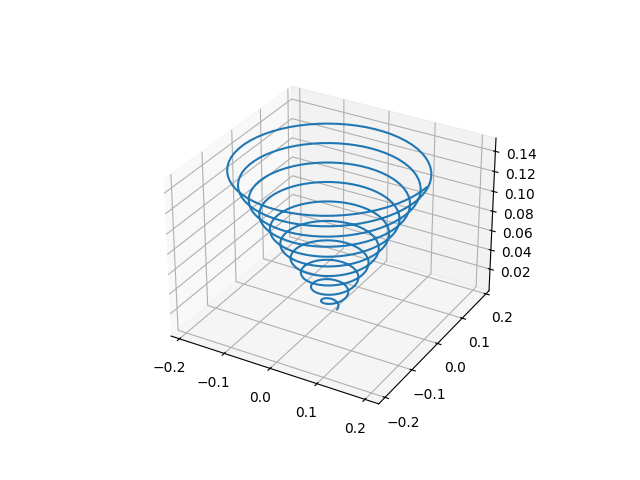

In [3]:
i = np.arange(1, 2*np.pi*Np/d_theta, 1)
xp = ((rp_f - rp_i) * i * d_theta / (2 * np.pi * Np) + rp_i) * np.cos(d_theta * i)
yp = ((rp_f - rp_i) * i * d_theta / (2 * np.pi * Np) + rp_i) * np.sin(d_theta * i)
zp = (zp_f - zp_i) * i * d_theta / (2 * np.pi * Np) + zp_i

ax = plt.figure().add_subplot(projection='3d')
plt.plot(xp, yp, zp)

### Sceondary Coil Discretization
The secondary coil is comprised of a series of circular coils stacked on top of eachother. To reduce computational complexity we opt to group the entire coil in "bunches", achieving an effective number of windings $N_s^\prime = \frac{N_s}{g}$, where $g$ is the grouping factor. 

Therefore each bunched coil is located at $z = \left\{j\frac{(z_f - z_i)}{N_s^\prime} + z_i \ \big| \ j = 0, 1, \dots, N_s^\prime - 1\right\}$ and having $x,y$ coordinates given by the usual expression
\begin{align}
    x(\theta) &= r_s \cos(\theta), \\
    y(\theta) &= r_s \sin(\theta) \ , \quad 0 \le \theta \le 2\pi.
\end{align}
The expression above is readily discretized as
\begin{align}
    x[i] &= r_s \cos(i\Delta\theta), \\
    y[i] &= r_s \sin(i\Delta\theta),
\end{align}
with $i = 0, 1, \dots, \frac{2\pi}{\Delta\theta}$.

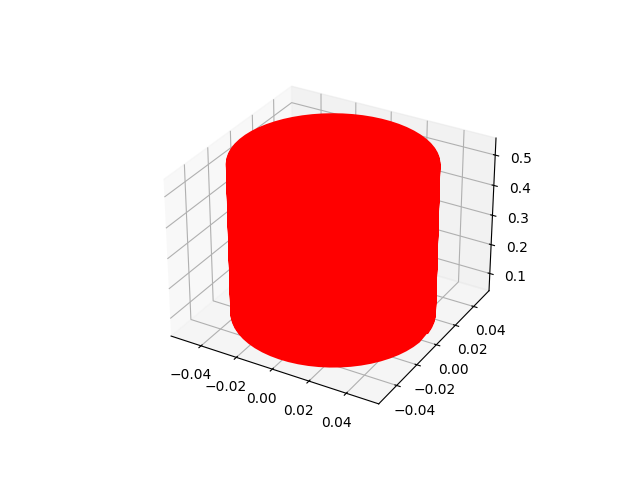

In [4]:
if Ns % group != 0:
    raise Exception("Grouping not allowed")

i = np.arange(1, 2*np.pi/d_theta, 1)

Ns_prime = int(Ns/group)
x_set = rs * np.cos(i * d_theta)
y_set = rs * np.sin(i * d_theta)
z_set = np.arange(0, Ns_prime, 1) * (zs_f - zs_i)/Ns_prime + zs_i

dim = x_set.size
xs = np.zeros(Ns_prime * dim)
ys = np.zeros(Ns_prime * dim)
zs = np.zeros(Ns_prime * dim)

for index, z_coil in enumerate(z_set):
    for i in range(index*dim, (index + 1)*dim):
        xs[i] = x_set[i - index*dim]
        ys[i] = y_set[i - index*dim]
        zs[i] = z_coil
        
ax = plt.figure().add_subplot(projection='3d')
plt.plot(xs, ys, zs, color='red')

### Resulting Geometry

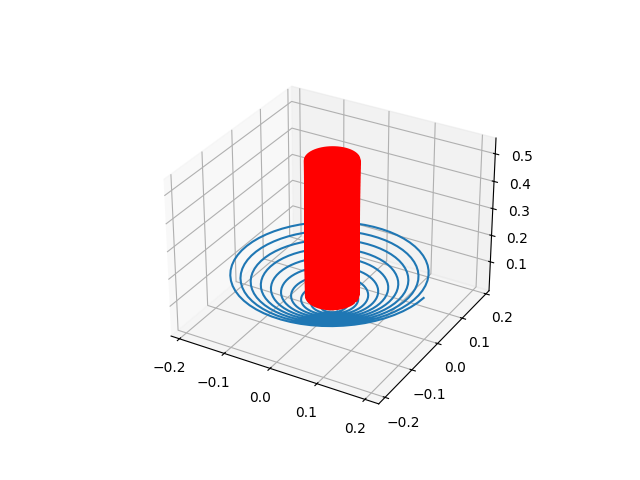

In [5]:
ax = plt.figure().add_subplot(projection='3d')
plt.plot(xp, yp, zp)
plt.plot(xs, ys, zs, color='red')

## Inductance Integrator
We now implement the Neumann integrator to calculate the inductance of two coils. To this end, we rewrite the formula we had at the beginning of the notebook
$$
M_{m, n} \approx \frac{\mu_0}{4\pi} \sum_{m}\sum_{n} \frac{\Delta\vec{x}_m \cdot \Delta\vec{x}_n}{\left|\vec{x}_m - \vec{x}_n\right|}.
$$

In [6]:
def neumann_mutual(x1, y1, z1, x2, y2, z2):
    dim1 = x1.size
    dim2 = x2.size
    
    integral = 0
    
    mu_0 = 4e-7 * np.pi 
    
    for i1 in range(dim1 - 1):
        x1_i = np.array([x1[i1], y1[i1], z1[i1]])
        x1_f = np.array([x1[i1 + 1], y1[i1 + 1], z1[i1 + 1]])
        dx1 = x1_f - x1_i
        for i2 in range(dim2 - 1):
            x2_i = np.array([x2[i2], y2[i2], z2[i2]])
            x2_f = np.array([x2[i2 + 1], y2[i2 + 1], z2[i2 + 1]])
            dx2 = x2_f - x2_i
            
            denom = np.linalg.norm(x2_i - x1_i)
            if denom == 0: 
                continue
            integral = integral + np.dot(dx1, dx2) / denom
    
    return integral * mu_0 / (4*np.pi)
            

# Self inductance is just mutual on same path
def neumann_self(x1, y1, z1):
    return neumann_mutual(x1, y1, z1, x1, y1, z1)

In [7]:
Lp = neumann_self(xp, yp, zp)
Ls = neumann_self(xs, ys, zs)*group
M  = neumann_mutual(xp, yp, zp, xs, ys, zs)
k  = M/np.sqrt(Lp*Ls)

In [8]:
Lp

1.1708954507927676e-05

In [9]:
Ls

0.0016957654164830155

In [10]:
M

9.913576451141647e-06

In [11]:
k

0.07035393833668678